In [1]:
import Bio
Bio.__version__

'1.85'

In [22]:
from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral

from IPython.display import Image, HTML

import os
import random
from typing import List

In [3]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

# A bit of helper code to shorten long text
def head(text, lines=10):
    """Print the first lines lines of the passed text."""
    print('\n'.join(text.split('\n')[:lines] + ['[...]']))

In [4]:
# Information about the Kyoto Encyclopedia of Genes and Genomes
print(kegg_info("kegg").read())

kegg             Kyoto Encyclopedia of Genes and Genomes
kegg             Release 113.0+/03-26, Mar 25
                 Kanehisa Laboratories
                 pathway         578 entries
                 brite       418,694 entries
                 module          582 entries
                 orthology    27,475 entries
                 genome       25,464 entries
                 genes     59,397,436 entries
                 compound     19,460 entries
                 glycan       11,232 entries
                 reaction     12,242 entries
                 rclass        3,202 entries
                 enzyme        8,235 entries
                 network       1,593 entries
                 variant       1,535 entries
                 disease       2,892 entries
                 drug         12,622 entries
                 dgroup        2,498 entries



In [5]:
# Information about the KEGG Pathway Database
print(kegg_info("pathway").read())

pathway          KEGG Pathway Database
path             Release 113.0+/03-27, Mar 25
                 Kanehisa Laboratories
                 578 entries

linked db        module
                 ko
                 <org>
                 genome
                 compound
                 glycan
                 reaction
                 rclass
                 enzyme
                 network
                 disease
                 drug
                 pubmed



In [6]:
# List all pathways in the pathway database
head(kegg_list('pathway').read())

map01100	Metabolic pathways
map01110	Biosynthesis of secondary metabolites
map01120	Microbial metabolism in diverse environments
map01200	Carbon metabolism
map01210	2-Oxocarboxylic acid metabolism
map01212	Fatty acid metabolism
map01230	Biosynthesis of amino acids
map01232	Nucleotide metabolism
map01250	Biosynthesis of nucleotide sugars
map01240	Biosynthesis of cofactors
[...]


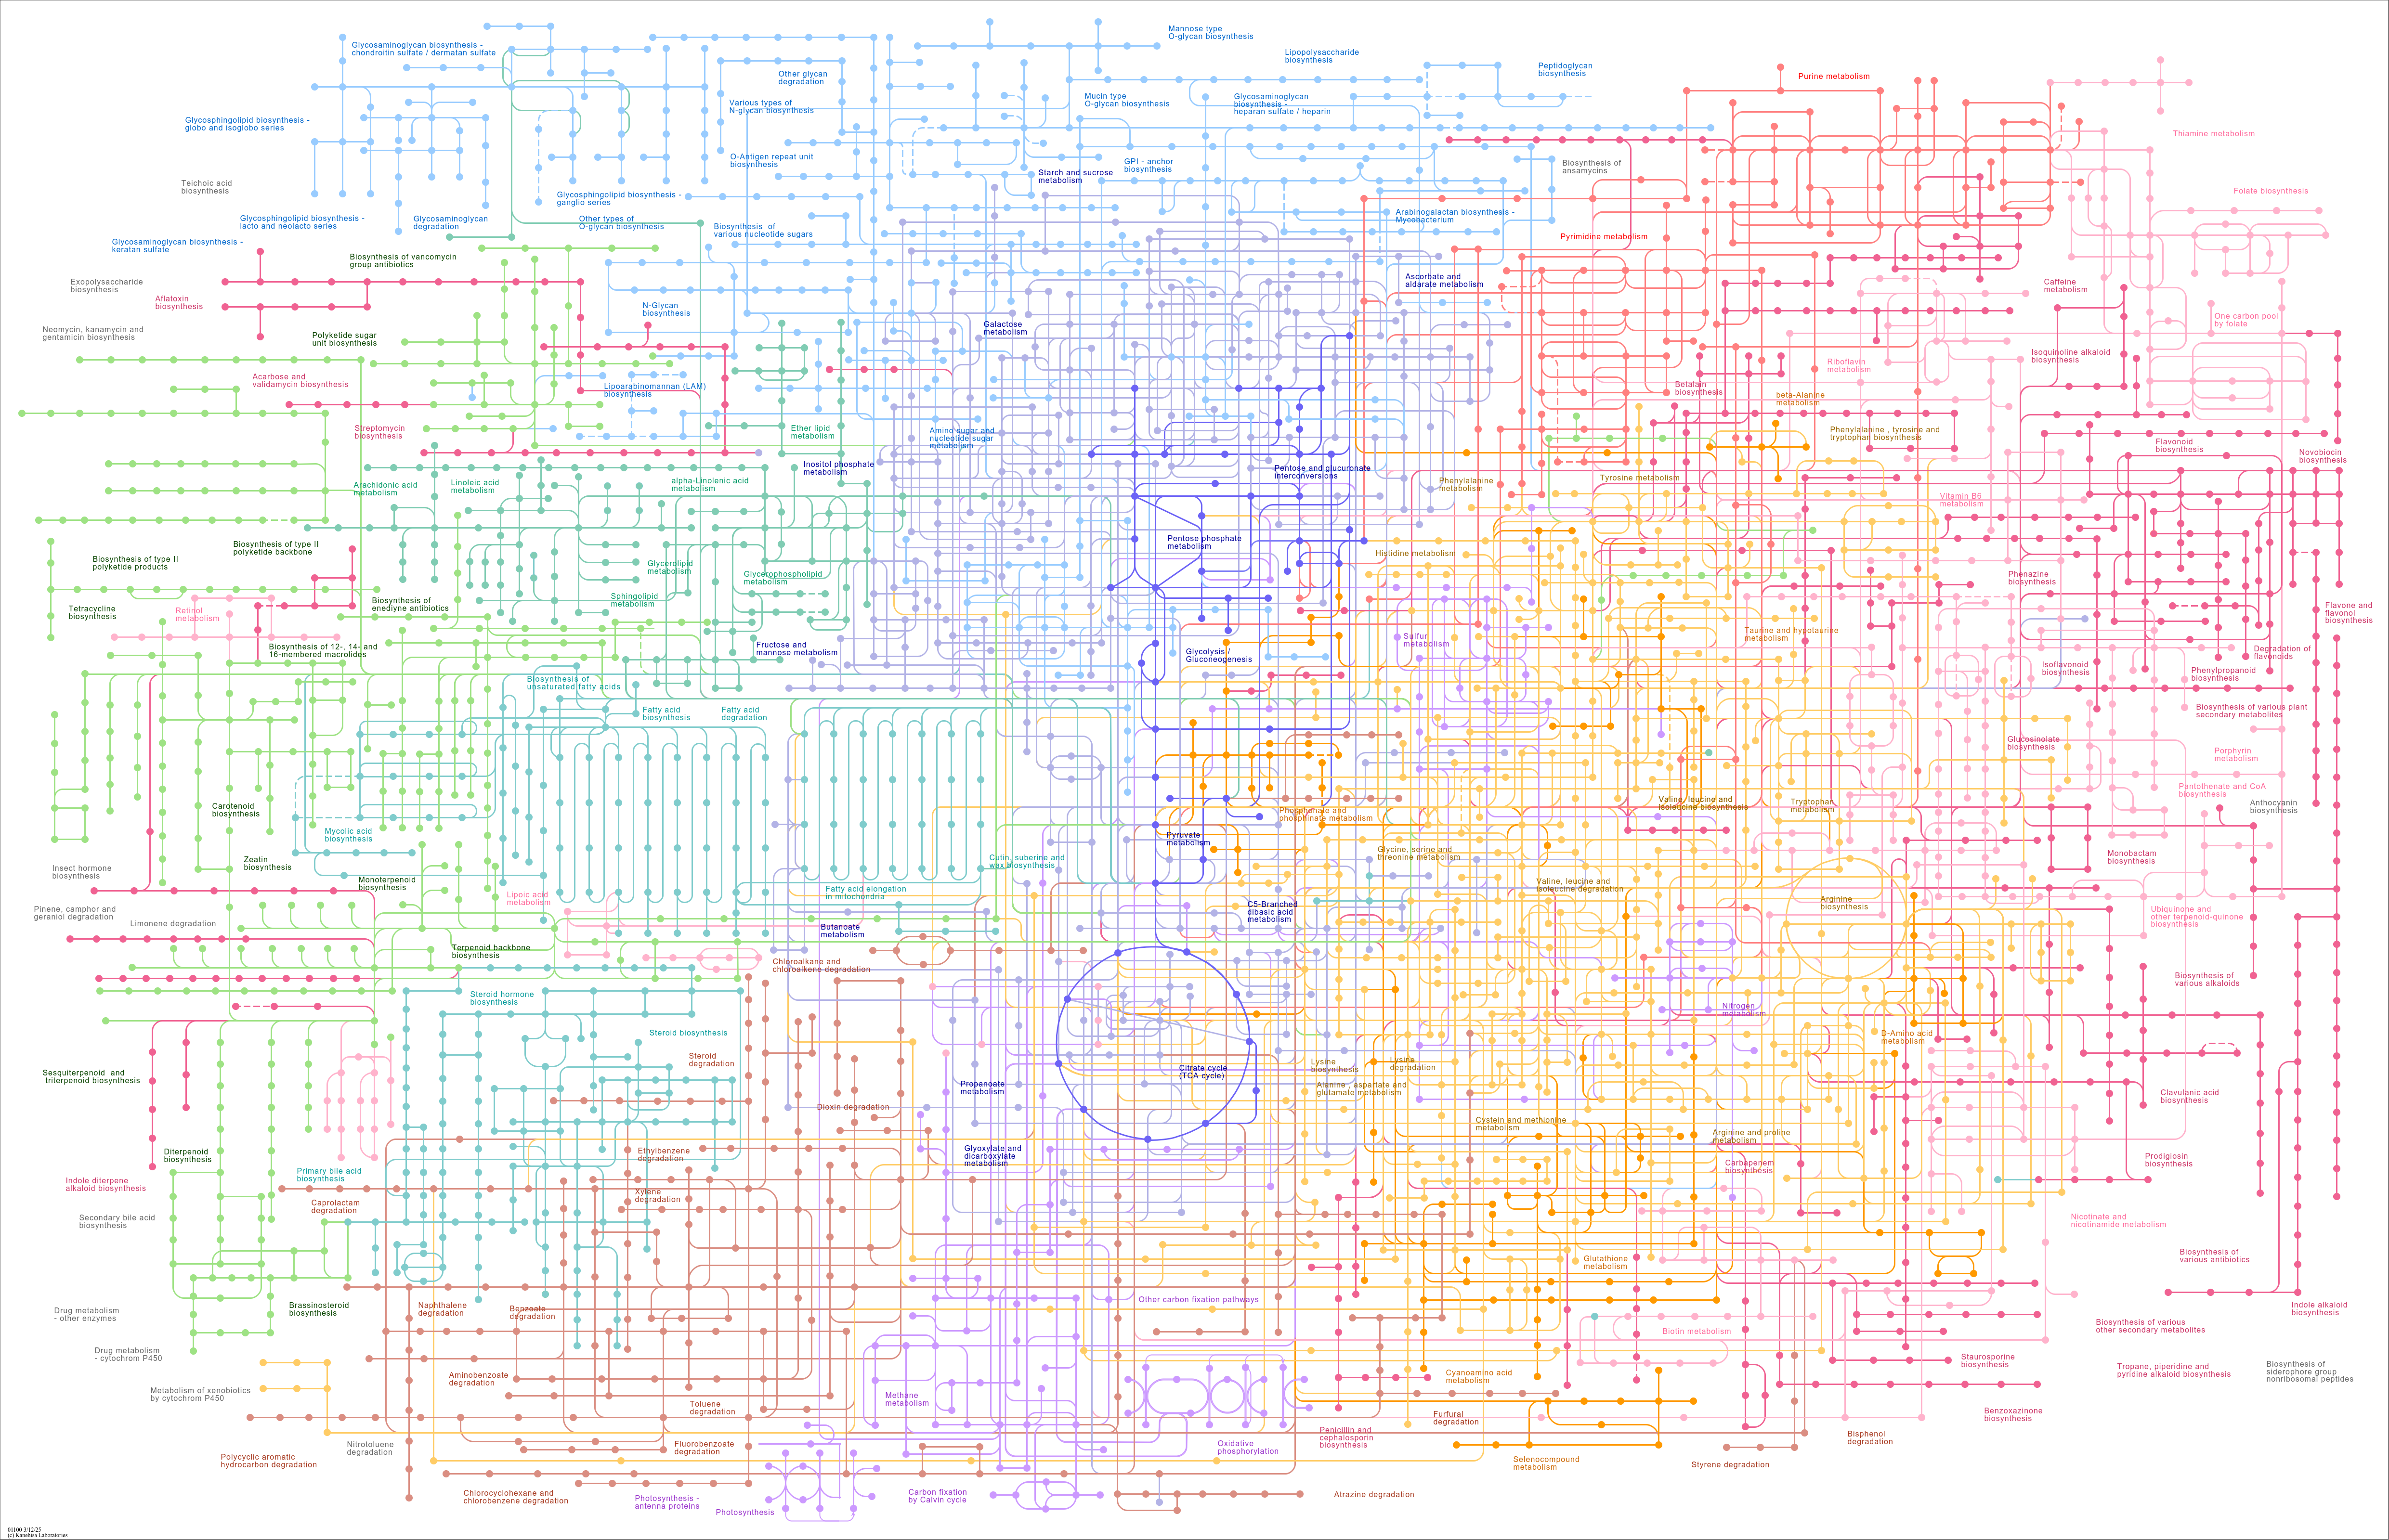

In [7]:
# Render central metabolism
Image(kegg_get("map01100", "image").read())

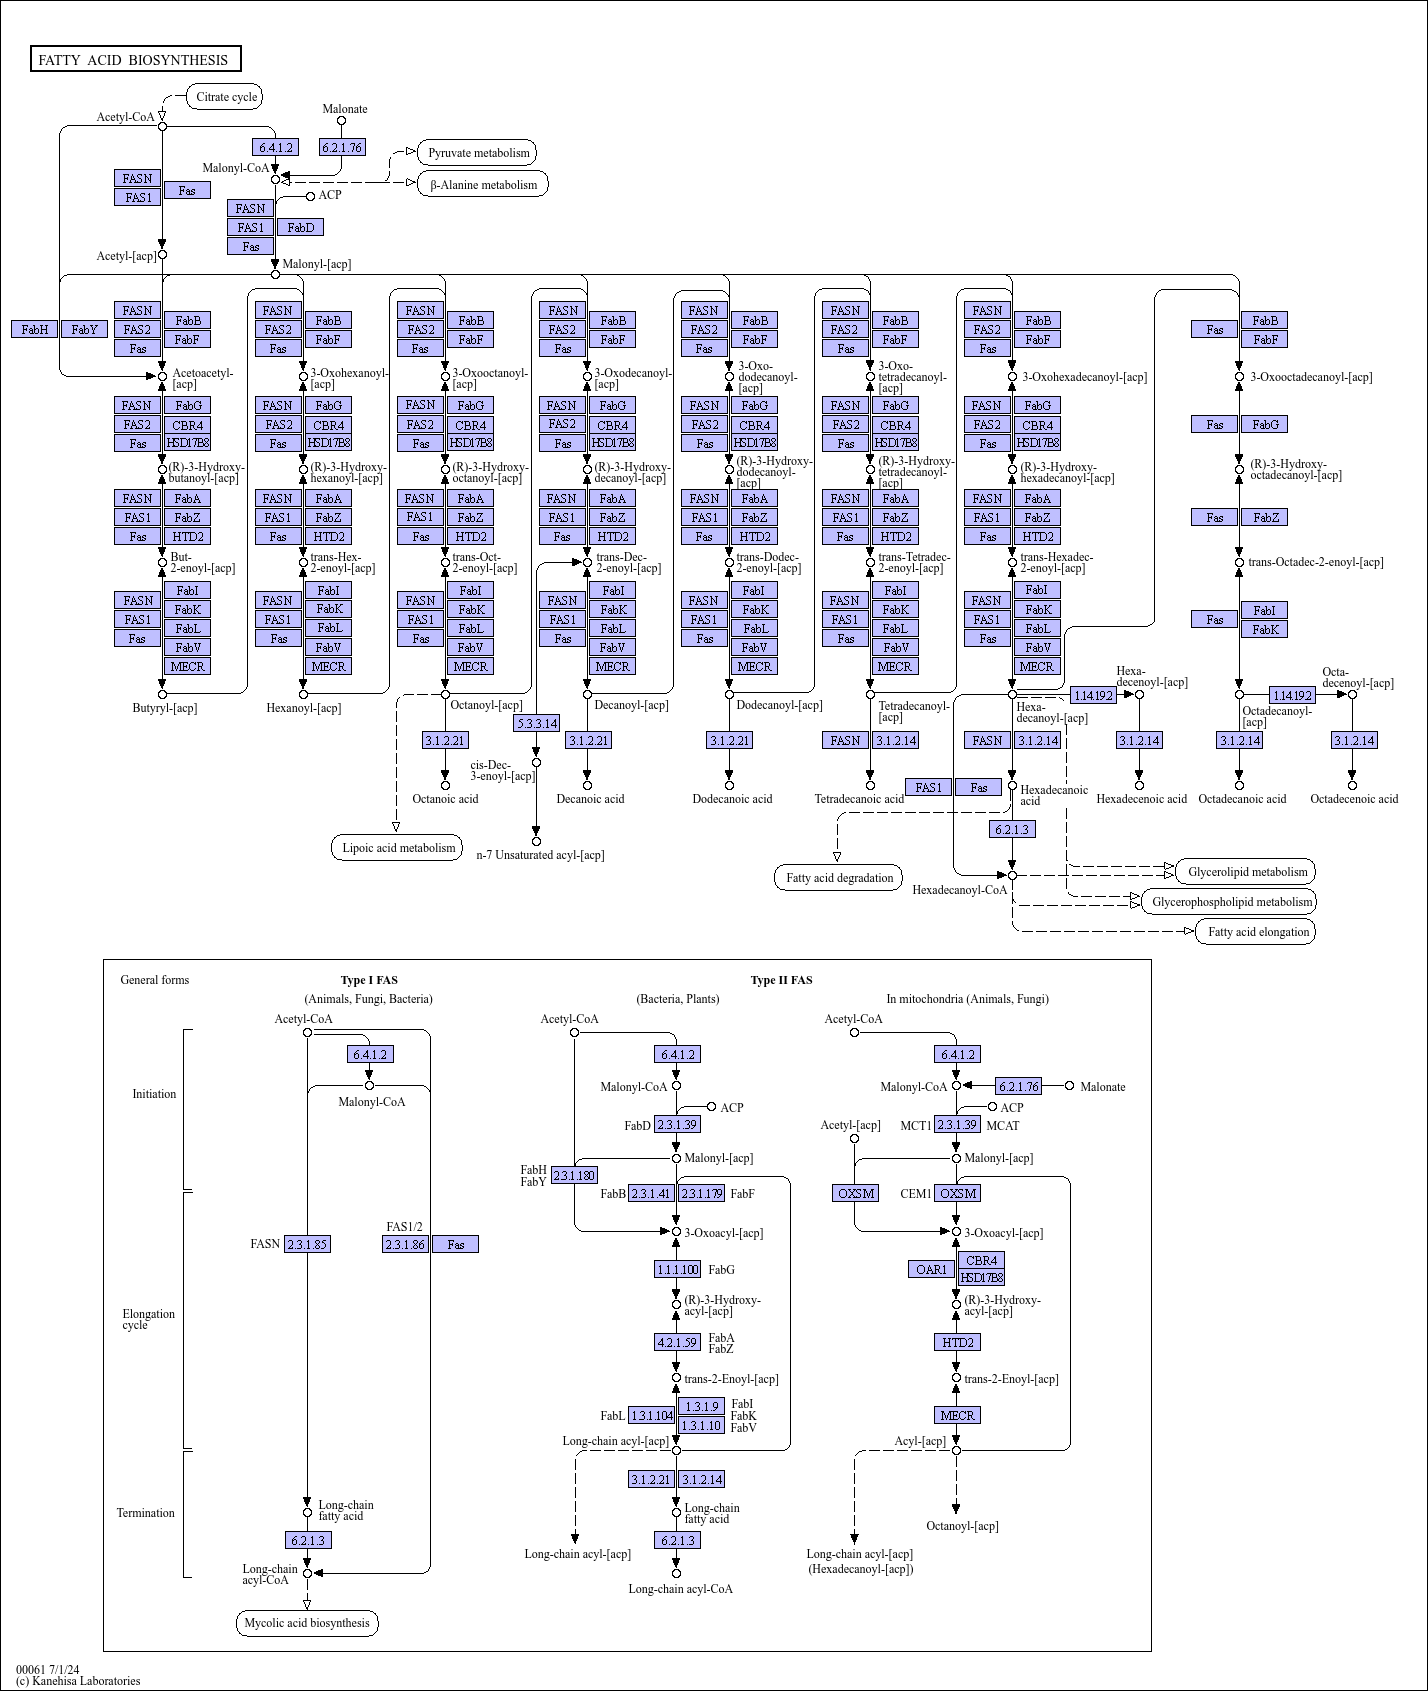

In [8]:
# Render reference fatty-acid biosynthesis
Image(kegg_get("ko00061", "image").read())

In [20]:
help(kegg_get)

Help on function kegg_get in module Bio.KEGG.REST:

kegg_get(dbentries, option=None)
    KEGG get - Data retrieval.
    
    dbentries - Identifiers (single string, or list of strings), see below.
    option - One of "aaseq", "ntseq", "mol", "kcf", "image", "kgml" (string)
    
    The input is limited up to 10 entries.
    The input is limited to one pathway entry with the image or kgml option.
    The input is limited to one compound/glycan/drug entry with the image option.
    
    Returns a handle.



In [10]:
pathway = KGML_parser.read(kegg_get("ko00061", "kgml"))
canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw("fab_map_with_image.pdf")
PDF( "fab_map_with_image.pdf")

/Users/helenscott/opt/miniconda3/envs/med4-hot1a3/lib/python3.10/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [11]:
pathway.orthologs[:5]

In [12]:
print(pathway.orthologs[0])

Entry node ID: 26
Names: ko:K02371
Type: ortholog
Components: set()
Reactions: rn:R04969
Graphics elements: 1 [<Bio.KEGG.KGML.KGML_pathway.Graphics object at 0x10c4d9450>]



In [13]:
pathway.orthologs[0].graphics

In [14]:
element = pathway.orthologs[0].graphics[0]
attrs = ["name", "x", "y", "coords", "type", "width", "height",
         "fgcolor", "bgcolor", "bounds", "centre"]
for a in attrs:
    print("element.{0: <10}:\t{1}".format(a, getattr(element, a)))

element.name      :	K02371
element.x         :	1037.0
element.y         :	609.0
element.coords    :	None
element.type      :	rectangle
element.width     :	46.0
element.height    :	17.0
element.fgcolor   :	#000000
element.bgcolor   :	#BFBFFF
element.bounds    :	[(1014.0, 600.5), (1060.0, 617.5)]
element.centre    :	(1037.0, 609.0)


In [15]:
# Helper function to convert colour as RGB tuple to hex string
def rgb_to_hex(rgb):
    rgb = tuple([int(255*val) for val in rgb])
    return '#' + ''.join([hex(val)[2:] for val in rgb]).upper()

In [16]:
# Define arbitrary colours
colorspiral = ColorSpiral()
colorlist = colorspiral.get_colors(len(pathway.orthologs))

# Change the colours of ortholog elements
for color, element in zip(colorlist, pathway.orthologs):
    for graphic in element.graphics:
        graphic.bgcolor = rgb_to_hex(color)

In [17]:
canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw("fab_map_new_colours.pdf")
PDF("fab_map_new_colours.pdf")

In [18]:
# Make all squares white
for element in pathway.orthologs:
    for graphic in element.graphics:
        graphic.bgcolor = "#FFFFFF"

canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw("fab_map_no_colours.pdf")
PDF("fab_map_no_colours.pdf")

In [19]:
# Convert PDF to PNG
os.system("convert fab_map_no_colours.pdf fab_map_no_colours.png")

0

# Pseudo code

Inputs
* Map number
* KO list
* Color
* Folder with KGMLs

If map not in foler, download it
Load map

Convert colors

Save to PDF
Convert to PNG

In [ ]:
def map_ko_ids(pathway_id: str, ko_ids = List[str], color = "#BFBFFF", kgml_folder = None, output_folder = "."):
    """Render a KEGG pathway with highlighted KO identifiers, save as a PDF and a PNG."""
    # If the pathway's KGML file is not already downloaded, download it
    if not os.path.exists(os.path.join(kgml_folder, pathway_id + ".xml")):
        with open(os.path.join(kgml_folder, pathway_id + ".xml"), "w") as f:
            f.write(kegg_get(pathway_id, "kgml").read())
    
    # Get the path to the KGML file
    file_path = os.path.join(kgml_folder, pathway_id + ".xml")
    
    # Read the KGML file
    with open(file_path, "r") as f:
        pathway = KGML_parser.read(f)

    # Make all squares white, except for the ones with the KO identifiers
    for element in pathway.orthologs:
        for graphic in element.graphics:
            if graphic.name in ko_ids:
                graphic.bgcolor = color
            else:
                graphic.bgcolor = "#FFFFFF"
    
    # Render the map
    canvas = KGMLCanvas(pathway, import_imagemap=True)

    # Save the file as a PDF and convert it to a PNG
    canvas.draw(os.path.join(output_folder, pathway_id + ".pdf"))
    os.system("convert {0}.pdf {0}.png".format(os.path.join(output_folder, pathway_id)))



In [39]:
ko_ids = ["K00665", "K00668"]
map_ko_ids("ko00061", ko_ids, kgml_folder='.')